# Analytics Prototype (Elephant Hunter v 0.1)

We want to build a flexible analytics suite which can analyze and predict anomalous market motion, and capitalize on it. The end goal is to feed a trained machine learning system tick data, and have it, using historical data, predict the outcomes and their expected payoffs, by ranking the set of possible actions it will provide instructions to conduct automated trading. As a first step, we first want to analyze the behavior of the S&P 500 index in the opening hour of the market 9:30 - 10:30 on Mondays. To do this we will use Python to aggregate the data and then construct a number of descriptive statistics.

These import statements include the pandas package, which is perfectly suited for data analysis. Datetime to handle the date and time information of the tick data, and matplotlib so that graphs are visible within the notebook.

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
%matplotlib inline

The dates.txt file is a semicolon separated string of numbers generated from Matlab. The file I was given was surrounded by two brackets "[ ]" which I went in and deleted. This command generates a list of the dates and trims off the final entry which is blank. It then closes the file.

In [2]:
file = open("dates.txt","r")

for line in file:
    fields = line.split(";")
    
file.close()

fields = fields[:-1]

The dates provided are in Matlab format which is a six-digit number and a fraction of the day. We want to identify these numbers with actual dates and times, so the below method converts Matlab times into Pyhton datetimes, which are readily understandable to humans.

In [3]:
def mlt_to_dt(matlab_datenum):
    python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return python_datetime

fields = [mlt_to_dt(float(p)) for p in fields]

ES.txt is minute-by-minute tick data of the S&P 500 separated by commas, we split the txt file and turn it into a Python list. We again remove the last entry in the list as it is blank.

In [4]:
file = open("ES.txt","r")

for line in file:
    fields1 = line.split(",")
    
file.close()

In [5]:
fields1=fields1[:-1]
fields1=[float(i) for i in fields1]

Now that we have loaded both our datetimes and our S&P Prices into Python, we combine them into a dataframe. This approach is scalable to include many other assets, but for now we'll only include the S&P. There is a built in calendar in Python that we'll use to filter down the available data into trading days before 4pm. 

In [89]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015-11-14', end='2017-11-14').to_pydatetime()

df=pd.DataFrame(fields1,index=fields,columns=['ES_price'])
df.index = df.index.round('1min')
df=df[(df.index.dayofweek<5) & (df.index.hour<16) & (~df.index.isin(holidays))]

In [90]:
df.describe()

,ES_price
count,492543.000000
mean,2214.545897
std,201.776074
min,1767.500000
25%,2047.000000
50%,2165.750000
75%,2390.000000
max,2593.500000


We see that we have 492,543 data points to work with. Now we will start generating descriptive statistics and analyze a small subsection of the data.

In [91]:
df['price_change'] = df['ES_price'] - df['ES_price'].shift(+1)

In [92]:
df['2nd'] = df['price_change'] - df['price_change'].shift(+1)

In [93]:
df['Volatility'] = df['ES_price'].rolling(window=30,center=False).std()

In [94]:
df['15min_max'] = df['ES_price'].rolling(window=15,center=False).max()

In [95]:
df['15min_min'] = df['ES_price'].rolling(window=15,center=False).min()

In [96]:
df['max_min_spread'] = df['15min_max'] - df['15min_min']

The above six cells detail the price change, the change of the change in price (or 2nd derivative, 2nd) and rolling volatility with a window of 30 minutes, the 15 minute max and min and the spread between min and max. It is worth noting that the window size of the volatility is adjustable, and center = False guarantees that we only include previous prices in computing our volatility.

Let's now focus our attention on the time frame of 9:30 to 10:30 each Monday. Below are the descriptive statistics for the change in price from 9:30 to 9:31 on Monday.

In [45]:
df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31)]['price_change'].describe()

count    103.000000
mean       0.160194
std        0.923452
min       -2.750000
25%       -0.500000
50%        0.250000
75%        0.750000
max        2.250000
Name: price_change, dtype: float64

We see that the average move is 0.16 ticks, and the upper quartile of moves (meaning the top 25% of price changes) fall between 0.75 and 2.25. We want to further examine the set of events which have large (upper quartile) price changes and use the subsequent motion of the underlying to see what is average for large initial moves. Below we also see histograms of the price change, and the second derivative. We notice that the average second derivative is positive.

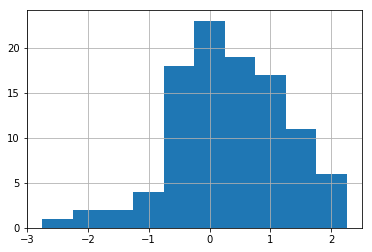

In [46]:
df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31)]['price_change'].hist()

In [116]:
df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31)]['2nd'].describe()

count    103.000000
mean       0.177184
std        1.414054
min       -3.500000
25%       -0.750000
50%        0.000000
75%        1.000000
max        4.250000
Name: 2nd, dtype: float64

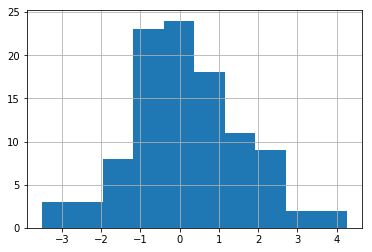

In [47]:
df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31)]['2nd'].hist()

Here we construct 4 empty lists and cycle through the aggregated data of tick data for which the 9:31 price increase is in the top 25% of events (>= 0.75). We append to these lists descriptive statistics. We then pass these four lists into a data frame and print the data frame. Included in the data frame is a column for the cumulative return,which is the cumulative sum of price changes. 

In [103]:
minimums = []
maximums = []
mean_returns = []
std_dev = []
time_window=pd.date_range("09:32", "10:30", freq="1min").time
for i in range(1,60): 
    if(i < 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 0.75)]['price_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 0.75)]['price_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 0.75)]['price_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 9) & (df.index.minute==31+i) & (df.price_change.shift(i) >= 0.75)]['price_change'].std())
        i+=1
    elif(i >= 29):
        minimums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75)]['price_change'].min())
        maximums.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75)]['price_change'].max())
        mean_returns.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75)]['price_change'].mean())
        std_dev.append(df[(df.index.weekday == 0) & (df.index.hour == 10) & (df.index.minute==i-29) & (df.price_change.shift(i) >= 0.75)]['price_change'].std())
        i+=1


In [122]:
df_930_1030=pd.DataFrame(minimums,index=time_window,columns=['min'])
df_930_1030['max'] = maximums
df_930_1030['mean'] = mean_returns
df_930_1030['std_dev'] = std_dev
df_930_1030['cumulative_return'] = df_930_1030['mean'].cumsum(axis = 0)

In [123]:
df_930_1030

,min,max,mean,std_dev,cumulative_return
09:32:00,-2.50,1.75,-0.044118,0.903425,-0.044118
09:33:00,-1.75,1.50,0.014706,0.863707,-0.029412
09:34:00,-1.50,2.00,0.139706,0.793418,0.110294
09:35:00,-2.25,2.50,0.051471,1.060266,0.161765
09:36:00,-3.00,1.00,-0.301471,0.801938,-0.139706
09:37:00,-1.50,2.00,0.176471,0.732186,0.036765
09:38:00,-1.75,2.50,0.014706,0.878922,0.051471
09:39:00,-1.75,4.75,0.367647,1.089265,0.419118
09:40:00,-2.50,2.25,0.080882,0.897641,0.500000
09:41:00,-1.25,1.00,0.051471,0.650697,0.551471


Below is a plot of the cumulative return on average between 9:32 and 10:30

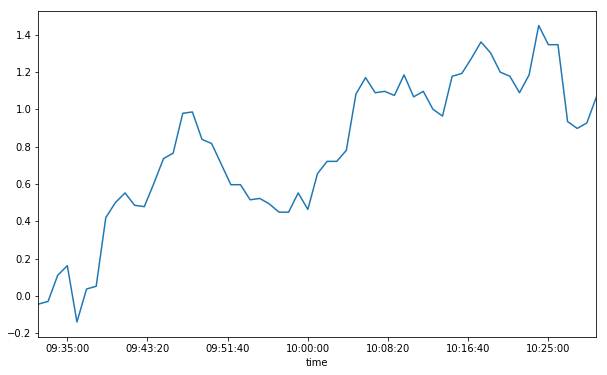

In [125]:
df_930_1030['cumulative_return'].plot(figsize=(10,6))